## Drought variables across CMIP6 
Research Computing for Earth Sciences Final Project <br>
December 2020 <br>
Miriam Nielsen

### Research Question
What is the relationship between drought-associated variables across CMIP6 Historical Model Experiments?



In [17]:
# Needed Packages
import cartopy.crs as ccrs
import cartopy
import zarr
import fsspec
import intake

import numpy as np
import pandas as pd
import xarray as xr
import dask 
import xesmf as xe
xr.set_options(display_style='html')

from tqdm.autonotebook import tqdm  # progress bars for loops

from dask_gateway import Gateway
from dask.distributed import Client

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

from IPython import display
display.set_matplotlib_formats('retina')


### Create Dask Cluster

TK description of CMIP6 size

using a dask cluster that (ideally) scales adaptively to parellelize the analysis

In [18]:
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt(minimum=1, maximum=20)
client = Client(cluster)
cluster

ValueError: Cluster ooi-prod.3b596e5f6a1f4df4a2125fa3163727d2 not found

### Data Loading & Organizing

In [19]:
# open pangeo catalogue of CMIP6 experiments
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

# open using intake
col = intake.open_esm_datastore(cat_url)
#Summary of collection structure
# col

/srv/conda/envs/notebook/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Contains many unique experiments

In [20]:
# print(col.df.experiment_id.unique())
# print(len(col.df.experiment_id.unique()))

I only want to look at models and experiments that include all three variables of interest: `tas`, `tasmax`, and `mrsos`

TK EXPLAIN BELOW

In [21]:
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
models = set(uni_dict['source_id']['values']) # all the models

for variable_id in ['tas', 'tasmax','mrsos']:
    query = dict(variable_id = variable_id)
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

models = list(models)

experiments = set(uni_dict['experiment_id']['values'])

for model in models:
    query = dict(variable_id = variable_id)
    cat = col.search(**query)
    experiments = experiments.intersection({experiment for experiment in cat.df.experiment_id.unique().tolist()})

experiments = list(experiments)
print(len(experiments))
print(experiments)
    

55
['esm-ssp585', 'amip-future4K', 'hist-GHG', 'amip', 'amip-m4K', 'piClim-HC', 'historical', 'piControl', 'piClim-2xNOx', 'esm-pi-CO2pulse', 'histSST-1950HC', 'piClim-control', 'hist-piNTCF', 'amip-lwoff', 'piClim-2xss', 'abrupt-4xCO2', 'ssp370-ssp126Lu', 'piClim-NOx', 'abrupt-solp4p', 'piClim-CH4', 'highresSST-present', 'hist-noLu', 'land-hist', 'esm-pi-cdr-pulse', 'amip-p4K-lwoff', 'esm-hist', 'land-noLu', 'highresSST-future', 'ssp370', '1pctCO2', 'piClim-aer', 'amip-4xCO2', 'piClim-2xVOC', '1pctCO2-bgc', '1pctCO2-cdr', 'piClim-2xdust', '1pctCO2-rad', 'ssp245', 'histSST-piNTCF', 'hist-1950HC', 'hist-nat', 'ssp119', 'histSST-piCH4', 'hist-aer', 'abrupt-solm4p', 'ssp126-ssp370Lu', 'abrupt-2xCO2', 'esm-piControl', 'esm-ssp585-ssp126Lu', 'land-hist-altStartYear', 'amip-p4K', 'piClim-NTCF', 'abrupt-0p5xCO2', 'ssp126', 'ssp585']


In [22]:
query = dict(
    # WHICH EXPERIMENTS SHOULD I USE??? 
    # options: 'historical', 'ssp245', 'ssp585' <- lots for tas, idk about other variables
    
    experiment_id=['1pctCO2', 'piControl'],       # pick the `piControl` and TK TK forcing experiments
    variable_id=['tas', 'tasmax','mrsos'],        # near-surface air temperature (tas), maximum surface air temperature (tasmax), and surface soil moisture (mrsos)
    # WHICH REALIZATION SHOULD I USE?? 
    member_id = 'r1i1p1f1',                       # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()


,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,2,3,2
BCC-CSM2-MR,2,3,2
BCC-ESM1,2,3,2
CanESM5,2,3,3
GFDL-CM4,2,3,4
GFDL-ESM4,2,3,4
GISS-E2-1-G,2,3,2
GISS-E2-1-H,2,3,2
GISS-E2-2-G,2,3,2


In [23]:
def drop_all_bounds(ds):
    """Drop coordinates like 'time_bounds' from datasets,
    which can lead to issues when merging."""
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dsets(df):
    """Open datasets from cloud storage and return xarray dataset."""
    dsets = [xr.open_zarr(fsspec.get_mapper(ds_url), consolidated=True)
             .pipe(drop_all_bounds)
             for ds_url in df.zstore]
    try:
        ds = xr.merge(dsets, join='exact')
        return ds
    except ValueError:
        return None

def open_delayed(df):
    """A dask.delayed wrapper around `open_dsets`.
    Allows us to open many datasets in parallel."""
    return dask.delayed(open_dsets)(df)


In [24]:
from collections import defaultdict

dsets = defaultdict(dict)
for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [25]:
dsets_ = dask.compute(dict(dsets))[0]

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_asarr

### Global Mean Comparison
Reduce data with global mean, weighted by a factor proportional to cos(lat)

In [26]:
def get_lat_name(ds):
    """Figure out what is the latitude coordinate for each dataset."""
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    """Return global mean of a whole dataset."""
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [27]:
expts = ['piControl', '1pctCO2']
expt_da = xr.DataArray(expts, dims='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year - ds.time.dt.year[0]

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].pipe(global_mean)
                             .swap_dims({'time': 'year'})
                             .drop('time')
                             .coarsen(year=12).mean()
                      for expt in expts]

    # align everything
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='right',
                                 dim=expt_da)

Missing experiment for BCC-CSM2-MR
Missing experiment for BCC-ESM1
Missing experiment for CanESM5
Missing experiment for GFDL-CM4
Missing experiment for GFDL-ESM4
Missing experiment for IPSL-CM6A-LR
Missing experiment for MIROC6
Missing experiment for MRI-ESM2-0
Missing experiment for SAM0-UNICON



In [28]:
dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [33]:
dsets_aligned_

{'ACCESS-CM2': <xarray.Dataset>
 Dimensions:        (experiment_id: 2, year: 150)
 Coordinates:
   * experiment_id  (experiment_id) object 'piControl' '1pctCO2'
   * year           (year) float64 0.0 1.0 2.0 3.0 ... 146.0 147.0 148.0 149.0
     height         float64 2.0
     depth          float64 0.011
 Data variables:
     tas            (experiment_id, year) float64 287.0 287.0 ... 293.0 293.2
     tasmax         (experiment_id, year) float64 288.8 288.8 ... 294.8 294.9
     mrsos          (experiment_id, year) float64 19.93 19.82 ... 18.73 18.8
     None           (experiment_id) <U9 'piControl' '1pctCO2',
 'GISS-E2-1-G': <xarray.Dataset>
 Dimensions:        (experiment_id: 2, year: 151)
 Coordinates:
   * experiment_id  (experiment_id) object 'piControl' '1pctCO2'
   * year           (year) float64 0.0 1.0 2.0 3.0 ... 147.0 148.0 149.0 150.0
     height         float64 2.0
     depth          float64 0.05
 Data variables:
     tas            (experiment_id, year) float64 286.9 28

In [29]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                   dim=source_da)
big_ds

<xarray.Dataset>
Dimensions:        (experiment_id: 2, source_id: 4, year: 151)
Coordinates:
  * source_id      (source_id) object 'ACCESS-CM2' ... 'GISS-E2-2-G'
  * year           (year) float64 0.0 1.0 2.0 3.0 ... 147.0 148.0 149.0 150.0
  * experiment_id  (experiment_id) object 'piControl' '1pctCO2'
Data variables:
    tas            (source_id, experiment_id, year) float64 287.0 ... 288.7
    tasmax         (source_id, experiment_id, year) float64 288.8 ... 290.6
    mrsos          (source_id, experiment_id, year) float64 19.93 ... 5.164
    None           (source_id) <U11 'ACCESS-CM2' 'GISS-E2-1-G' ... 'GISS-E2-2-G'

### TK SOME ANALYSIS

gridpoint correlations xr.corr(ds1, ds2, dim=‘time’)
pearsons corr coefficients


In [30]:
ds_mean = big_ds[['tas','tasmax','mrsos']].sel(experiment_id='piControl').mean(dim='year')
ds_anom = big_ds[['tas','tasmax','mrsos']] - ds_mean

# add some metadata
ds_anom.tas.attrs['long_name'] = 'Global Mean Surface Temp Anom'
ds_anom.tas.attrs['units'] = 'K'
ds_anom.tasmax.attrs['long_name'] = 'Global Mean Maximum Surface Temperature Anom'
ds_anom.tasmax.attrs['units'] = 'K'
ds_anom.mrsos.attrs['long_name'] = 'Global Mean Surface Soil Moisture Anom'
ds_anom.mrsos.attrs['units'] = 'kg m-2'
ds_anom

<xarray.Dataset>
Dimensions:        (experiment_id: 2, source_id: 4, year: 151)
Coordinates:
  * source_id      (source_id) object 'ACCESS-CM2' ... 'GISS-E2-2-G'
  * year           (year) float64 0.0 1.0 2.0 3.0 ... 147.0 148.0 149.0 150.0
  * experiment_id  (experiment_id) object 'piControl' '1pctCO2'
Data variables:
    tas            (source_id, experiment_id, year) float64 -0.03737 ... 3.864
    tasmax         (source_id, experiment_id, year) float64 -0.02875 ... 3.766
    mrsos          (source_id, experiment_id, year) float64 -0.01311 ... -0.3108

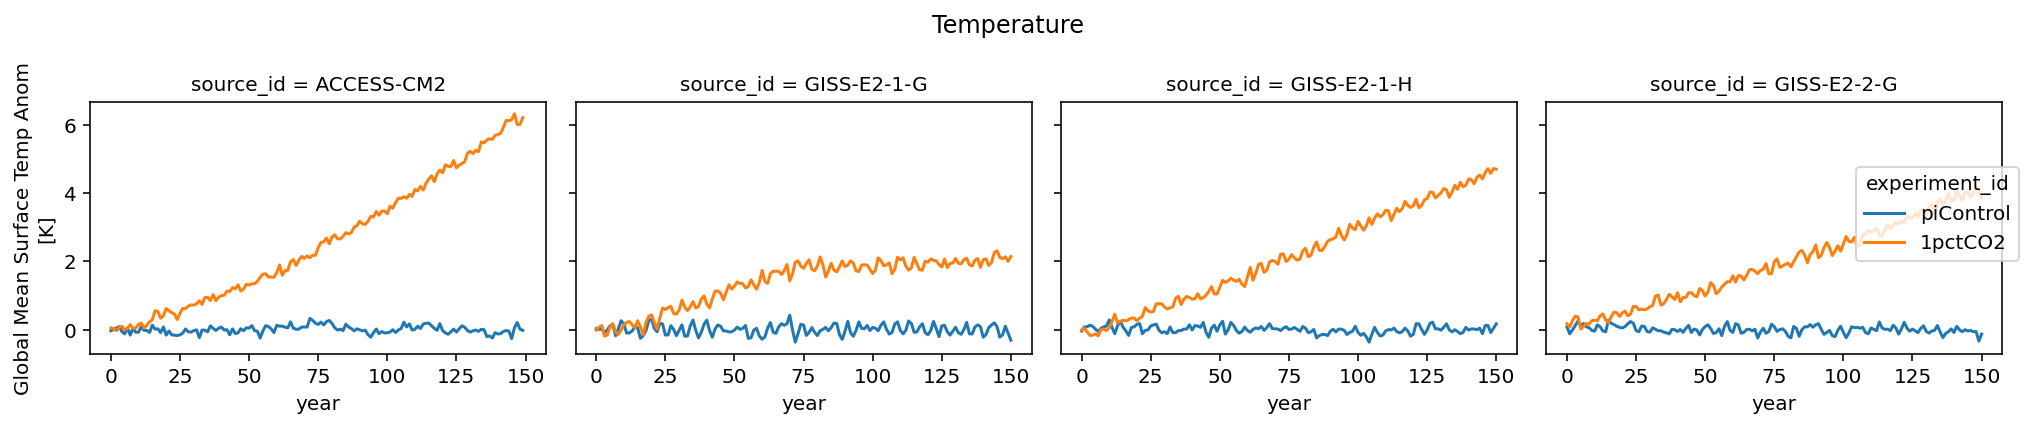

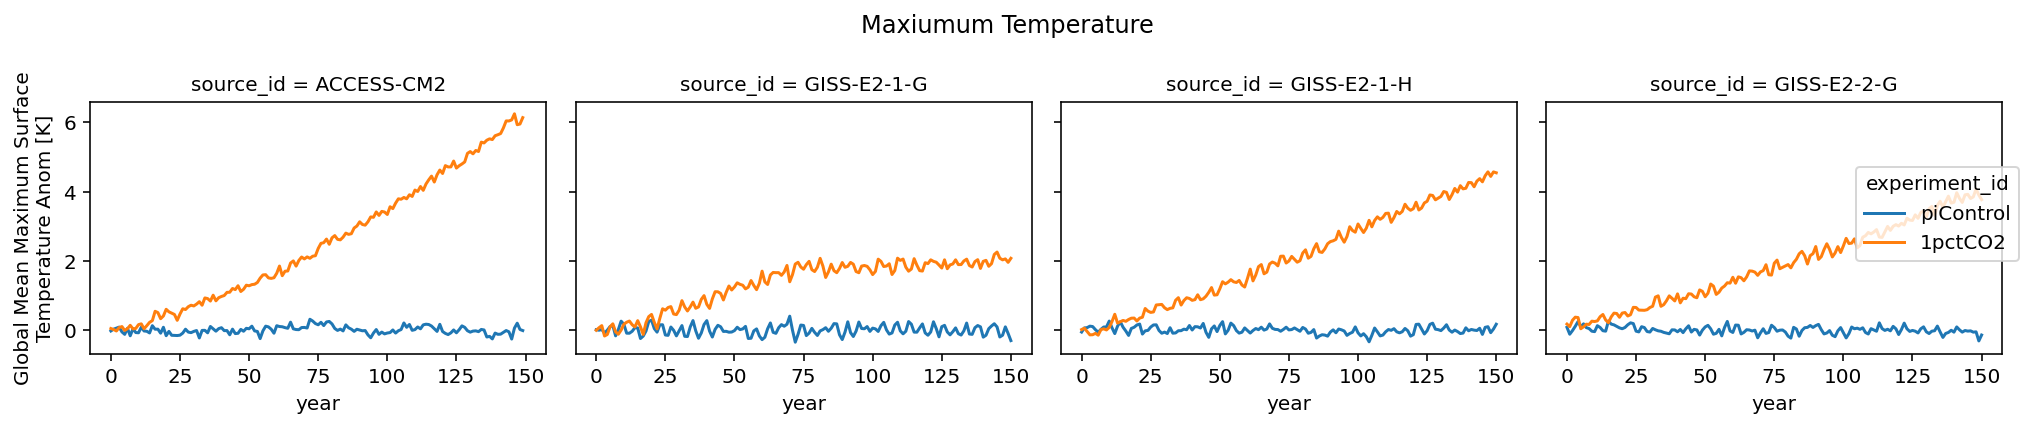

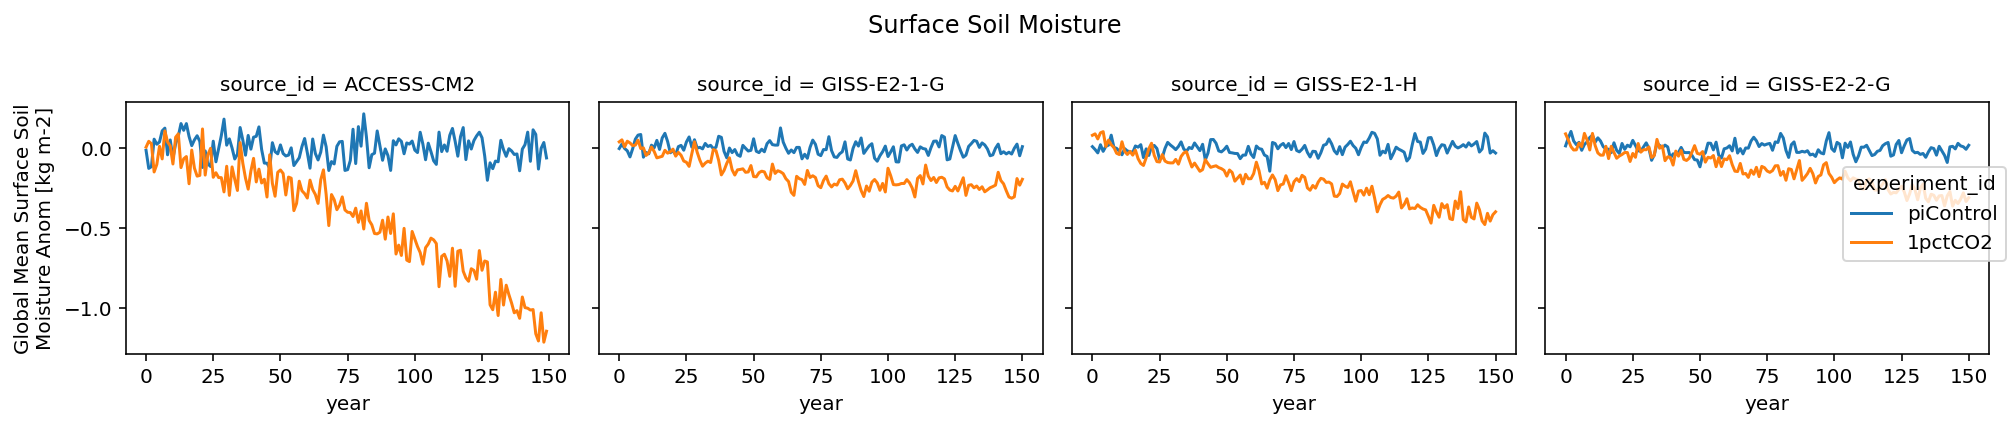

In [31]:
drought_vars = ['tas','tasmax','mrsos']
var_names = ['Temperature', 'Maxiumum Temperature', 'Surface Soil Moisture']

# TO DO - MAKE THIS ALL ONE FIGURE WITH A SINGLE LEGEND 
count = 0

for i in drought_vars:
    ds_anom[i].plot.line(col='source_id', x='year', col_wrap = 4) # expand col_wrap with more experiments
    plt.suptitle(var_names[count])
    count += 1
    plt.tight_layout()

### Correlation


correlation of time series

In [81]:
ds_corr = xr.DataArray()
tas = ds_anom['tas'].sel(experiment_id='1pctCO2')
ds_corr['tas'] = xr.corr(tas.sel(source_id = 'ACCESS-CM2'), tas.sel(source_id = 'GISS-E2-2-G'))
ds_corr['tasmax-smsos'] = xr.corr(ds_anom.tasmax.sel(experiment_id = '1pctCO2', source_id = 'GISS-E2-2-G'), 
                                  ds_anom.mrsos.sel(experiment_id = '1pctCO2', source_id = 'GISS-E2-2-G'))

AttributeError: 'Dataset' object has no attribute 'smsos'

In [ ]:
ds_corr = ds_anom
ds_corr['corr'] = xr.corr(ds_anom['tasmax'], ds_anom['mrsos'], dim= 'year')
ds_corr

In [49]:
def load_data(df):
    ''' Load dataset using zarr'''
    zstore = df.zstore.values[-1]
    
    # create a mutable-mapping-style interface to the store
    mapper = fsspec.get_mapper(zstore)
    
    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated = True)
    return ds

In [50]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_access = df.query("experiment_id == '1pctCO2' & variable_id == 'mrsos' & table_id == 'Lmon' & source_id == 'ACCESS-CM2' & member_id == 'r1i1p1f1'")
df_giss = df.query("experiment_id == '1pctCO2' & variable_id == 'mrsos' & table_id == 'Lmon' & source_id == 'GISS-E2-1-G' & member_id == 'r1i1p1f1'")

ds_giss = load_data(df_giss)
ds_access = load_data(df_access)


/srv/conda/envs/notebook/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [51]:
ds_giss

<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 90, lon: 144, time: 1812)
Coordinates:
    depth       float64 ...
    depth_bnds  (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
  * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time        (time) object 1850-01-16 12:00:00 ... 2000-12-16 12:00:00
    time_bnds   (time, bnds) object dask.array<chunksize=(1812, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    mrsos       (time, lat, lon) float32 dask.array<chunksize=(963, 90, 144), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.3.2
    comment:                1 percent per year increase in CO2 to 2xCO2
    contact:                Kenneth Lo (cdkkl@giss.nasa.gov)
    creation_date:          2018-10-17T19:24:14Z
    data_specs_version:     01.00.23
    experiment:             1 percent per year increase in CO2
    experiment_id:          1pctCO2
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NASA-GISS.GI...
    grid:                   atmospheric grid: 144x90, ocean grid: 288x180
    grid_label:             gn
    history:                2018-10-17T19:24:14Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            Goddard Institute for Space Studies, New York, NY...
    institution_id:         NASA-GISS
    license:                CMIP6 model data produced by NASA Goddard Institu...
    mip_era:                CMIP6
    model_id:               E200CO2x2aF40oQ40
    nominal_resolution:     250 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_experiment_rip:  r1i1p1
    parent_mip_era:         CMIP6
    parent_source_id:       GISS-E2-1-G
    parent_time_units:      days since 4150-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  land
    references:             https://data.giss.nasa.gov/modelE/cmip6
    source:                 GISS-E2.1G (2016): \naerosol: Varies with physics...
    source_id:              GISS-E2-1-G
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Lmon
    table_info:             Creation Date:(21 March 2018) MD5:f76dbc1e8bf6b7e...
    title:                  GISS-E2-1-G output prepared for CMIP6
    tracking_id:            hdl:21.14100/96d2fa5b-4aa1-427d-a212-0c068270026a...
    variable_id:            mrsos
    variant_label:          r1i1p1f1
    status:                 2019-10-30;created;by nhn2@columbia.edu

In [58]:
ds_access

<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 144, lon: 192, time: 1800)
Coordinates:
    depth       float64 ...
    depth_bnds  (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
  * lat         (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon         (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time        (time) object 0950-01-16 12:00:00 ... 1099-12-16 12:00:00
    time_bnds   (time, bnds) object dask.array<chunksize=(1800, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    mrsos       (time, lat, lon) float32 dask.array<chunksize=(900, 144, 192), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    creation_date:          2019-11-09T07:33:46Z
    data_specs_version:     01.00.30
    experiment:             1 percent per year increase in CO2
    experiment_id:          1pctCO2
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.CSIRO-ARCCSS...
    grid:                   native atmosphere N96 grid (144x192 latxlon)
    grid_label:             gn
    history:                2019-11-09T07:33:46Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institution_id:         CSIRO-ARCCSS
    license:                CMIP6 model data produced by CSIRO is licensed un...
    mip_era:                CMIP6
    nominal_resolution:     250 km
    notes:                  Exp: CM2-1pctCO2; Local ID: bk243; Variable: mrso...
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       ACCESS-CM2
    parent_time_units:      days since 0950-01-01
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  land
    run_variant:            forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2,...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    source_id:              ACCESS-CM2
    source_type:            AOGCM
    status:                 2020-08-08;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Lmon
    table_info:             Creation Date:(30 April 2019) MD5:e14f55f257cceaf...
    title:                  ACCESS-CM2 output prepared for CMIP6
    tracking_id:            hdl:21.14100/45d0140a-f67e-438d-8a82-55c241c0b92d
    variable_id:            mrsos
    variant_label:          r1i1p1f1
    version:                v20191109

In [90]:
# !pip install regionmask

In [78]:
import regionmask
mask = regionmask.defined_regions.natural_earth.land_110.mask(ds_giss)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


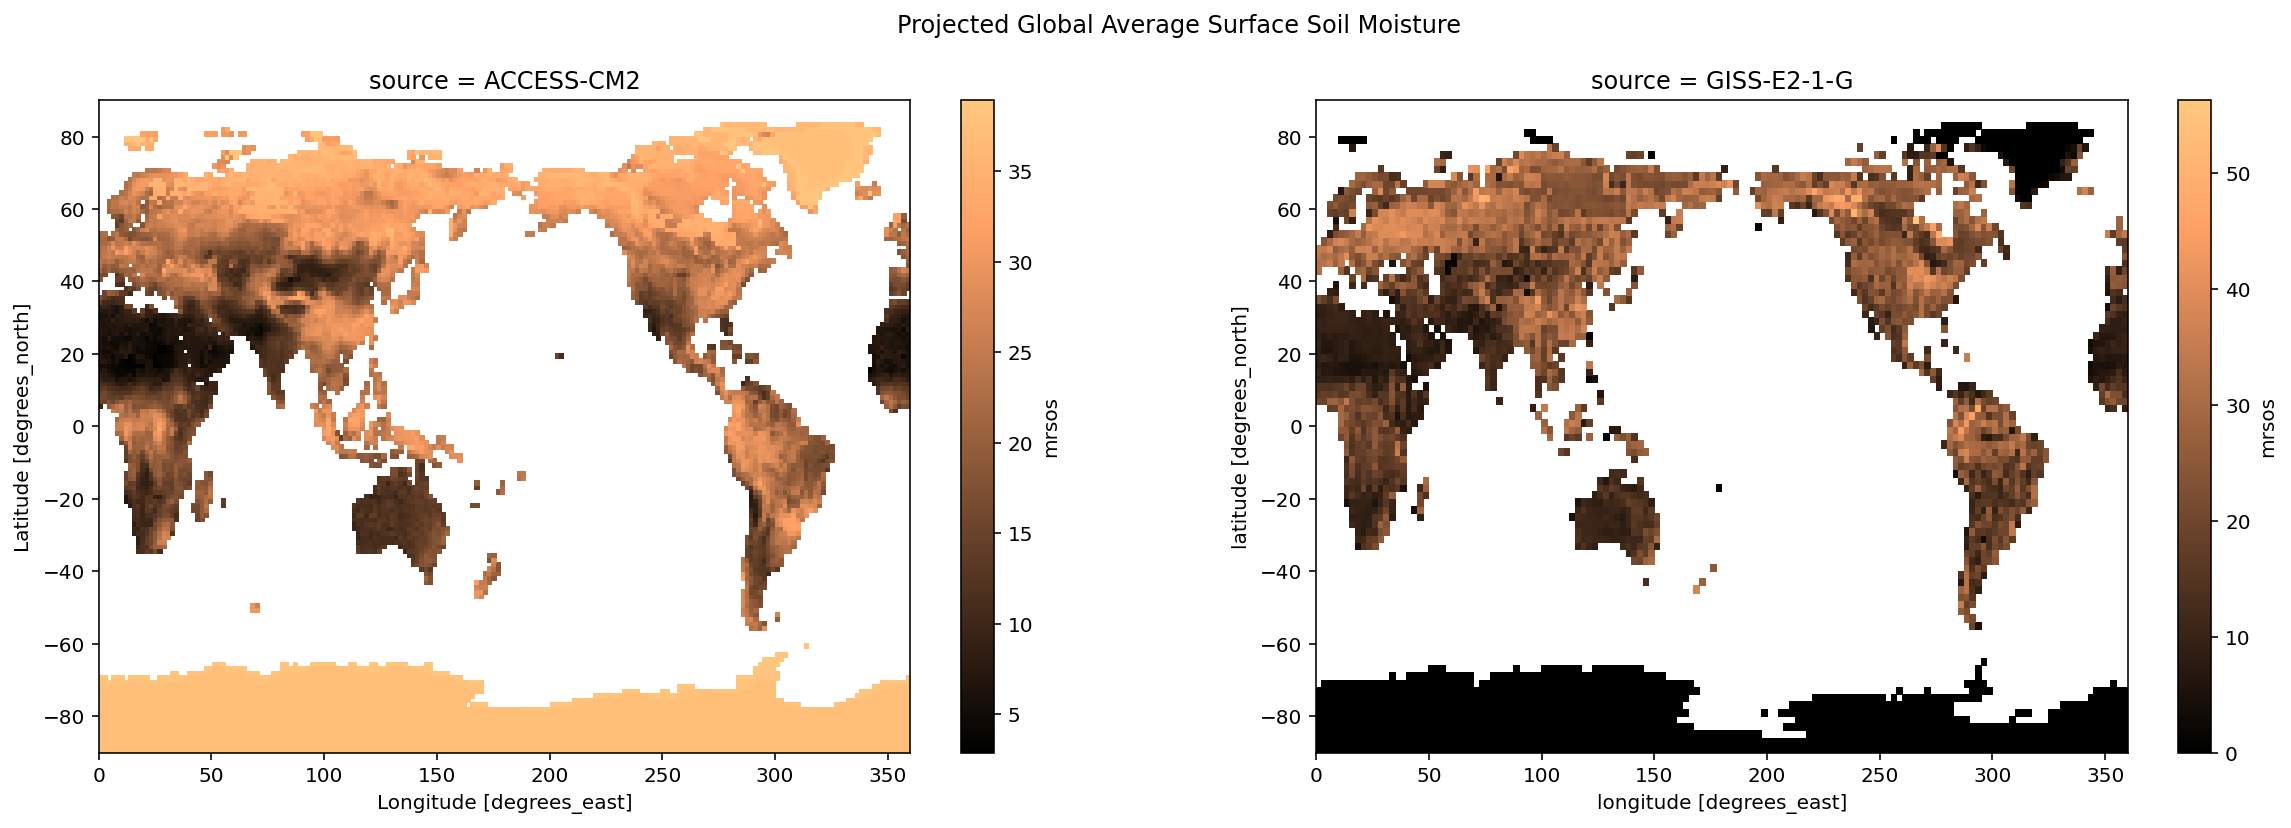

In [95]:
fig, ax = plt.subplots(ncols = 2, figsize = (20, 6))
ds_access.mrsos.mean(dim = 'time').plot(cmap = 'copper', ax = ax[0])
ax[0].set_title("source = ACCESS-CM2")

ds_giss.where(mask == 0).mrsos.mean(dim = 'time').plot(cmap = 'copper', ax = ax[1])
ax[1].set_title("source = GISS-E2-1-G")

plt.suptitle("Projected Global Average Surface Soil Moisture");

In [128]:
df_access_mrsos = df.query("experiment_id == '1pctCO2' & variable_id == 'mrsos' & table_id == 'Lmon' & source_id == 'ACCESS-CM2' & member_id == 'r1i1p1f1'")
df_access_tas = df.query("experiment_id == '1pctCO2' & variable_id == 'tas' & table_id == 'Amon' & source_id == 'ACCESS-CM2' & member_id == 'r1i1p1f1'")

ds_access_mrsos = load_data(df_access_mrsos)
ds_access_tas = load_data(df_access_tas)


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [130]:
mask = regionmask.defined_regions.natural_earth.land_110.mask(ds_access_mrsos)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Temperature')

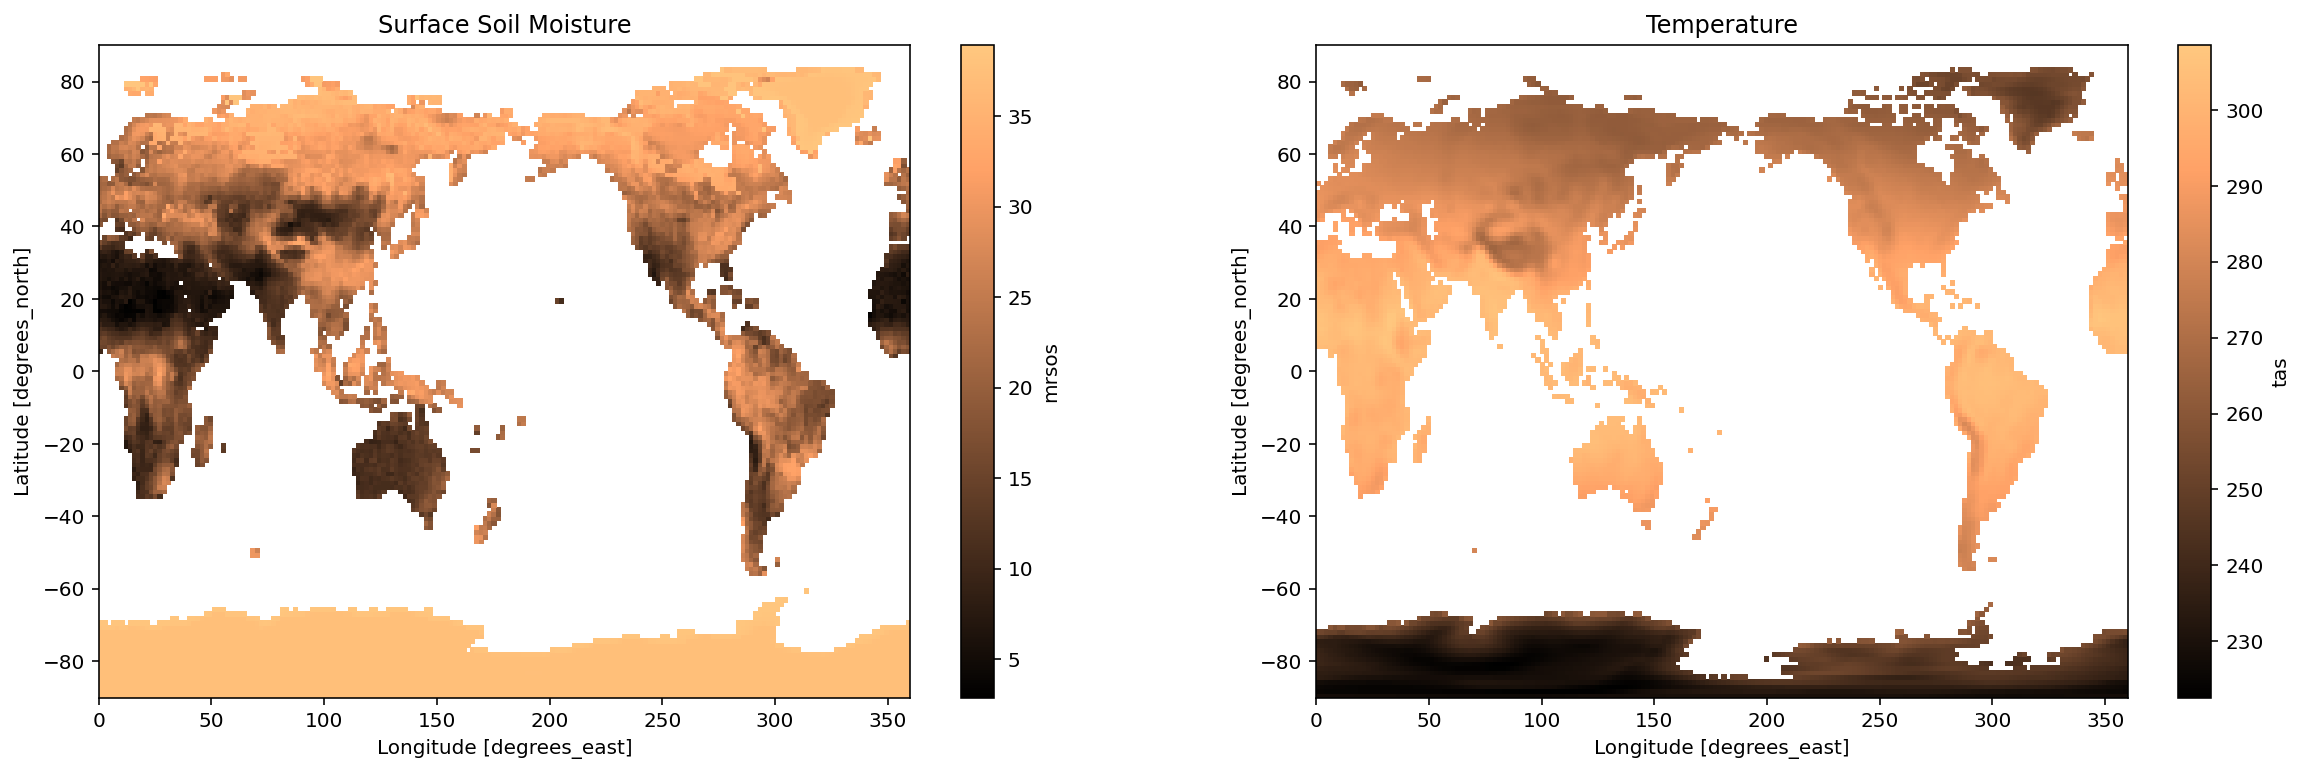

In [134]:
fig, ax = plt.subplots(ncols = 2, figsize = (20, 6))
ds_access_mrsos.mrsos.mean(dim = 'time').plot(cmap = 'copper', ax = ax[0])
ax[0].set_title("Surface Soil Moisture")

ds_access_tas.where(mask == 0).tas.mean(dim = 'time').plot(cmap = 'copper', ax = ax[1])
ax[1].set_title("Temperature")


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 75 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


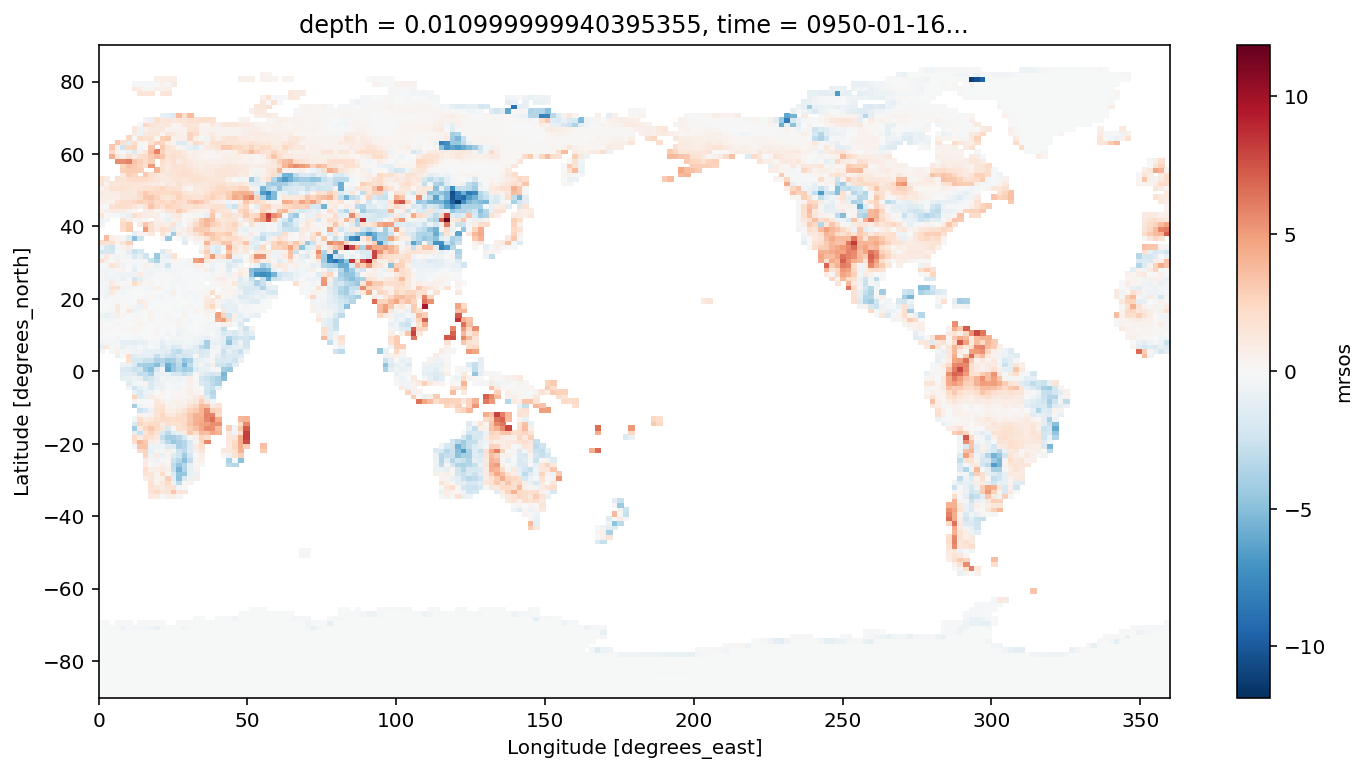

In [136]:
# following textbook correlation example: https://earth-env-data-science.github.io/lectures/xarray/xarray_tips_and_tricks.html

# surface soil mositure anomaly
mrsos = ds_access_mrsos.mrsos
mrsos_clim = mrsos.groupby('time.month').mean(dim = 'time')
mrsos_anom = mrsos.groupby('time.month') - mrsos_clim

mrsos_anom[0].plot()

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 50 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


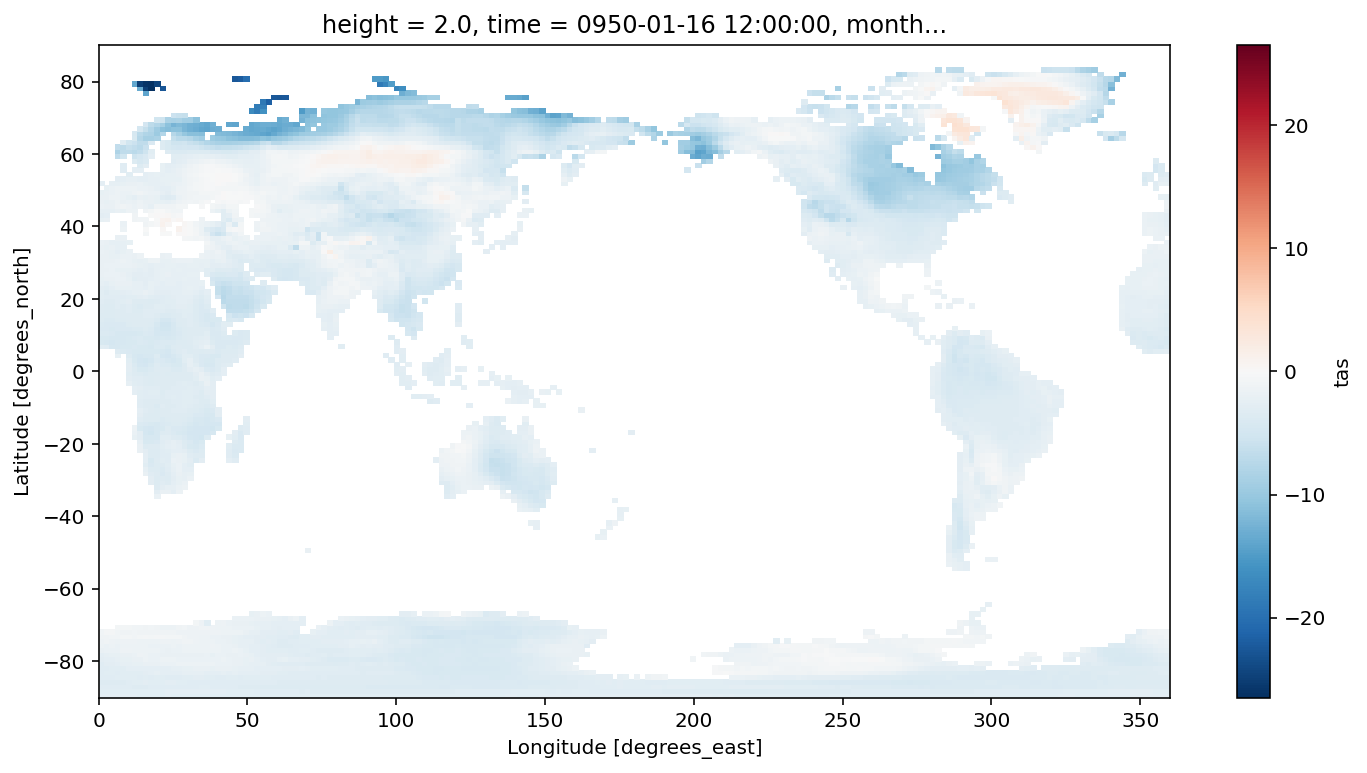

In [137]:
# temperature anomaly 

tas = ds_access_tas.where(mask ==0).tas
tas_clim = tas.groupby('time.month').mean(dim = 'time')
tas_anom = tas.groupby('time.month') - tas_clim

tas_anom[0].plot()

In [142]:
mrsos_tas_corr = xr.corr(mrsos_anom, tas_anom, dim = 'time')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


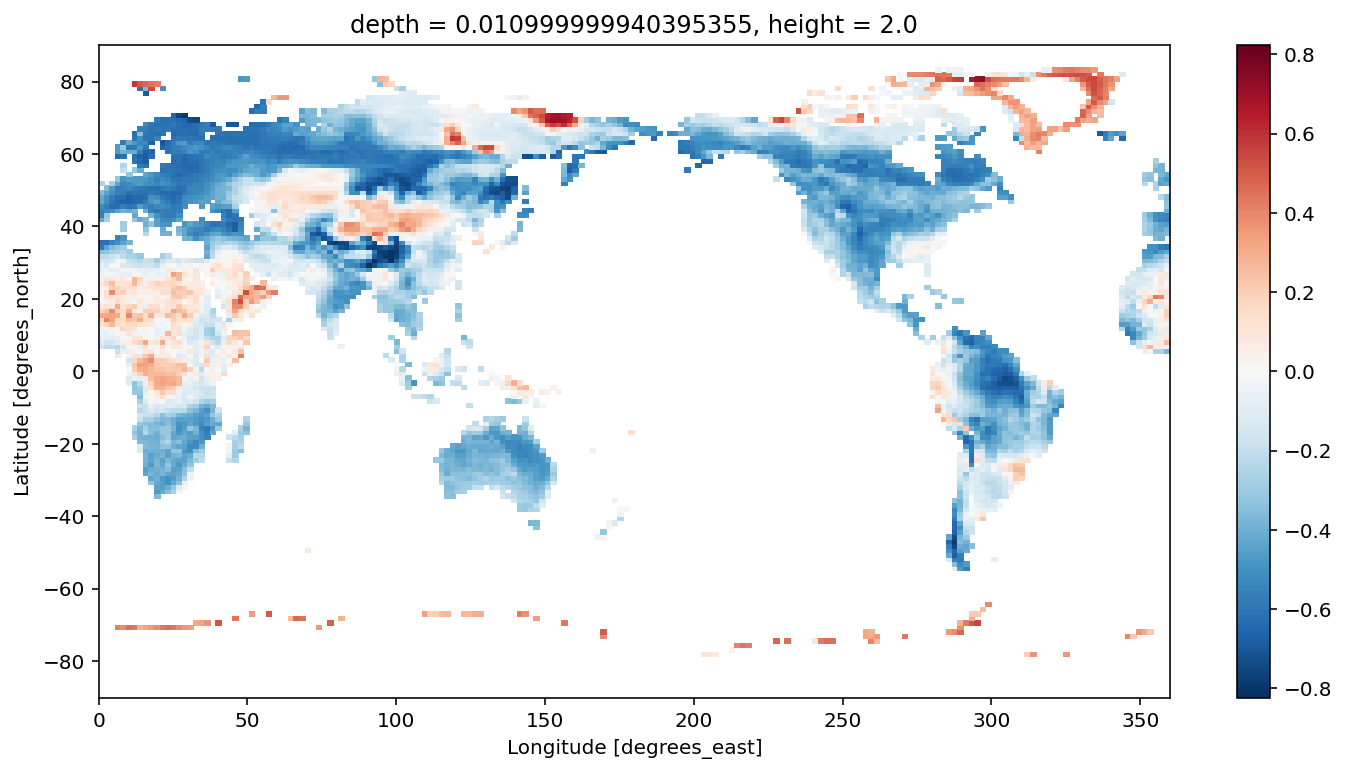

In [141]:
mrsos_tas_corr.plot()

In [102]:
ds_giss.mrsos.groupby('lat','lon').std('time').plot()

SyntaxError: positional argument follows keyword argument (<ipython-input-102-6b1af859489a>, line 1)

In [118]:
ds_giss.where(mask == 0).mrsos

<xarray.DataArray 'mrsos' (time: 1812, lat: 90, lon: 144)>
dask.array<where, shape=(1812, 90, 144), dtype=float32, chunksize=(963, 90, 144), chunktype=numpy.ndarray>
Coordinates:
    depth    float64 ...
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) object 1850-01-16 12:00:00 ... 2000-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean where land time: mean
    comment:        The mass of water in all phases in the upper 10cm of the ...
    long_name:      Moisture in Upper Portion of Soil Column
    standard_name:  moisture_content_of_soil_layer
    units:          kg m-2

In [119]:
corr = xr.corr(ds_giss.where(mask == 0).mrsos, ds_access.mrsos)

ValueError: not enough values to unpack (expected 3, got 0)

### Discussion

**TK**

TK

**TK**

TK

In [ ]:
# Gracefully destroy/close our cluster
client.close()
cluster.close()

#### References

This project uses code from several Pangeo CMIP Tutorials and CLEX CMS Blog including: <br>
[Drake and Abernathey, Estimating Equilibrium Climate Sensitivity (ECS) in CMIP6 models](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/ECS_Gregory_method.html)
[Wales, Per-gridpoint time correlation of two models](https://climate-cms.org/2019/07/29/multi-apply-along-axis.html)